> Code from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ with modifications.

In this seminar, we work with the "airline passengers" dataset, indicating the number of passengers over time. Let's start by loading the data!

Link: https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

In [1]:
import pandas as pd
df = pd.read_csv('airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [2]:
data_points = df[["Passengers"]].values.astype('float32')
data_points

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [30

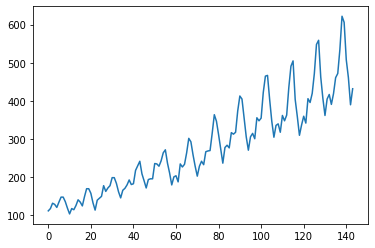

In [3]:
import matplotlib.pyplot as plt
plt.plot(data_points)
plt.show()

In [4]:
train_size = int(len(data_points) * 0.8)
train_data_points = data_points[:train_size]
test_data_points = data_points[train_size:]

sequence_size = 4

import torch

X_train, y_train = [], []
for i in range(len(train_data_points) - sequence_size):
    X_train.append(train_data_points[i:i+sequence_size])
    y_train.append(train_data_points[i+1:i+sequence_size+1])
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

X_test, y_test = [], []
for i in range(len(test_data_points) - sequence_size):
    X_test.append(test_data_points[i:i+sequence_size])
    y_test.append(test_data_points[i+1:i+sequence_size+1])
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

/var/folders/15/bmbcw71s1l12pc4g0617fwww0000gn/T/ipykernel_40783/826358318.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  X_train = torch.tensor(X_train)


In [5]:
import torch.nn as nn
from tqdm import tqdm

class SimpleRNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=64, num_layers=1, batch_first=True) # batch_first=True: (batch, seq_length, features), the format that comes from DataLoader
        self.linear = nn.Linear(64, 1)
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x)
        return x

As https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677 says regarding the outputs of the `rnn` function:


- out is the output of the RNN from all timesteps from the last RNN layer. It is of the size (seq_len, batch, num_directions * hidden_size). If batch_first=True, the output size is (batch, seq_len, num_directions * hidden_size).

- h_n is the hidden value from the last time-step of all RNN layers. It is of the size (num_layers * num_directions, batch, hidden_size). h_n is unaffected by batch_first=True

In [6]:
import numpy as np

def training_loop(model, number_of_epochs = 1000):
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True)
    loss_function = nn.MSELoss() # from PyTorch documentation: measures the mean squared error (squared L2 norm) between each element in the input x and target y
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in tqdm(range(number_of_epochs)):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            optimizer.zero_grad() # for every mini batch in training, set gradients to zero before the backprop
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 100 == 0 or epoch == number_of_epochs - 1:
            model.eval()
            with torch.no_grad(): # do not update the gradients -> no effect on backprop
                y_pred_train = model(X_train)
                y_pred_test = model(X_test)
                print(f"RMSE for epoch {epoch}: train {np.sqrt(loss_function(y_pred_train, y_train))}, test {np.sqrt(loss_function(y_pred_test, y_test))}")

    with torch.no_grad():
        # shift train predictions for plotting
        train_results = np.ones_like(data_points) * np.nan # an array with the same shape as data_points, filled with NaNs. Stores the training predictions for plotting (if NaN, it is not plotted)
        train_results[4:train_size] = model(X_train)[:, -1, :] # only keep the last prediction for each sequence in the batch
        # shift test predictions for plotting
        test_results = np.ones_like(data_points) * np.nan
        test_results[train_size+4:len(data_points)] = model(X_test)[:, -1, :]
    # plot
    plt.plot(data_points, c='r')
    plt.plot(train_results, c='g')
    plt.plot(test_results, c='b')
    plt.show()

From https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch:

model.train() tells your model that you are training the model. This helps inform layers such as Dropout and BatchNorm, which are designed to behave differently during training and evaluation. For instance, in training mode, BatchNorm updates a moving average on each new batch; whereas, for evaluation mode, these updates are frozen.

  0%|          | 4/1000 [00:00<00:56, 17.53it/s]

RMSE for epoch 0: train 248.2376251220703, test 442.794189453125


 11%|█         | 106/1000 [00:04<00:31, 28.67it/s]

RMSE for epoch 100: train 36.80834197998047, test 144.93267822265625


 20%|██        | 205/1000 [00:08<00:28, 28.01it/s]

RMSE for epoch 200: train 29.197769165039062, test 109.51982116699219


 30%|███       | 303/1000 [00:13<00:47, 14.79it/s]

RMSE for epoch 300: train 27.806264877319336, test 94.8164291381836


 41%|████      | 406/1000 [00:17<00:20, 29.18it/s]

RMSE for epoch 400: train 27.8165283203125, test 99.3706283569336


 50%|█████     | 505/1000 [00:20<00:17, 27.89it/s]

RMSE for epoch 500: train 25.77418327331543, test 90.3497543334961


 60%|██████    | 604/1000 [00:24<00:13, 29.14it/s]

RMSE for epoch 600: train 27.775592803955078, test 86.20764923095703


 71%|███████   | 706/1000 [00:27<00:10, 28.59it/s]

RMSE for epoch 700: train 26.038999557495117, test 88.95542907714844


 81%|████████  | 806/1000 [00:31<00:06, 29.53it/s]

RMSE for epoch 800: train 27.822477340698242, test 94.7621841430664


 90%|█████████ | 904/1000 [00:34<00:03, 26.85it/s]

RMSE for epoch 900: train 31.177526473999023, test 87.74742889404297


100%|██████████| 1000/1000 [00:38<00:00, 26.00it/s]

RMSE for epoch 999: train 25.891618728637695, test 84.2864990234375


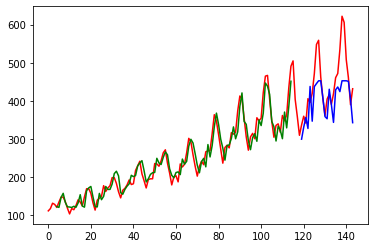

In [7]:
model = SimpleRNNModel()
training_loop(model)

  0%|          | 3/1000 [00:00<01:17, 12.90it/s]

RMSE for epoch 0: train 251.66552734375, test 446.4869384765625


 10%|█         | 103/1000 [00:07<00:59, 15.20it/s]

RMSE for epoch 100: train 41.86274337768555, test 152.73178100585938


 20%|██        | 203/1000 [00:14<00:58, 13.57it/s]

RMSE for epoch 200: train 27.32361602783203, test 91.3949203491211


 30%|███       | 303/1000 [00:21<00:45, 15.21it/s]

RMSE for epoch 300: train 25.076194763183594, test 85.40010070800781


 40%|████      | 403/1000 [00:28<00:39, 15.09it/s]

RMSE for epoch 400: train 27.000324249267578, test 88.91984558105469


 50%|█████     | 503/1000 [00:35<00:34, 14.54it/s]

RMSE for epoch 500: train 27.032108306884766, test 84.3886947631836


 60%|██████    | 603/1000 [00:42<00:28, 14.01it/s]

RMSE for epoch 600: train 23.915729522705078, test 78.1270523071289


 70%|███████   | 703/1000 [00:48<00:19, 15.21it/s]

RMSE for epoch 700: train 23.228641510009766, test 72.24260711669922


 80%|████████  | 803/1000 [00:55<00:13, 15.14it/s]

RMSE for epoch 800: train 23.47812843322754, test 72.56974792480469


 90%|█████████ | 903/1000 [01:02<00:06, 15.14it/s]

RMSE for epoch 900: train 23.517175674438477, test 69.63007354736328


100%|██████████| 1000/1000 [01:08<00:00, 14.58it/s]


RMSE for epoch 999: train 22.876998901367188, test 71.02112579345703


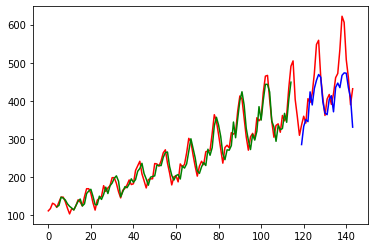

In [8]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.linear = nn.Linear(64, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = LSTMModel()
training_loop(model)

  0%|          | 3/1000 [00:00<01:38, 10.13it/s]

RMSE for epoch 0: train 248.76239013671875, test 443.3445129394531


 10%|█         | 103/1000 [00:06<00:51, 17.42it/s]

RMSE for epoch 100: train 36.96455001831055, test 137.48960876464844


 20%|██        | 203/1000 [00:11<00:46, 17.23it/s]

RMSE for epoch 200: train 26.418964385986328, test 90.94501495361328


 30%|███       | 303/1000 [00:17<00:39, 17.84it/s]

RMSE for epoch 300: train 25.757009506225586, test 88.41075134277344


 40%|████      | 403/1000 [00:23<00:33, 17.72it/s]

RMSE for epoch 400: train 26.63245391845703, test 85.4991683959961


 50%|█████     | 503/1000 [00:29<00:27, 17.83it/s]

RMSE for epoch 500: train 26.07852554321289, test 87.52980041503906


 60%|██████    | 603/1000 [00:35<00:22, 17.74it/s]

RMSE for epoch 600: train 27.62359619140625, test 88.74533081054688


 70%|███████   | 703/1000 [00:40<00:16, 17.78it/s]

RMSE for epoch 700: train 25.480579376220703, test 86.0707778930664


 80%|████████  | 803/1000 [00:46<00:11, 17.74it/s]

RMSE for epoch 800: train 25.72702407836914, test 78.04386138916016


 90%|█████████ | 903/1000 [00:52<00:05, 17.62it/s]

RMSE for epoch 900: train 28.141357421875, test 82.66927337646484


100%|██████████| 1000/1000 [00:59<00:00, 16.83it/s]


RMSE for epoch 999: train 26.156238555908203, test 75.82245635986328


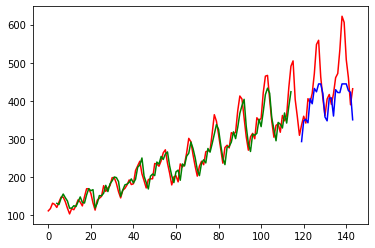

In [9]:
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.linear = nn.Linear(64, 1)
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x
    
model = GRUModel()
training_loop(model)